No images found in Dataset/ProcessedImages/Images


100%|██████████| 50/50 [06:45<00:00,  8.10s/it]


Disc Model Metrics:
Precision: 0.9654836663623448
F1 Score: 0.9666221319693521
IoU Score: 0.9354004588964974
Cup Model Metrics:
Precision: 0.9052005632416757
F1 Score: 0.8982977065530765
IoU Score: 0.8153724576015451


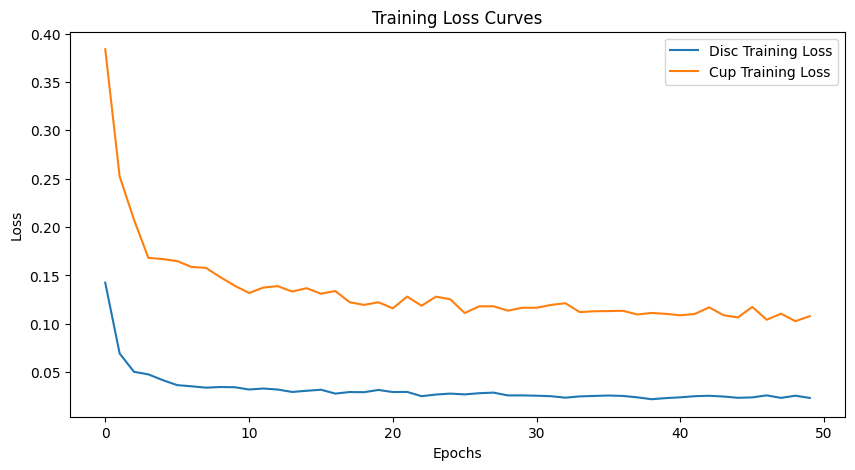

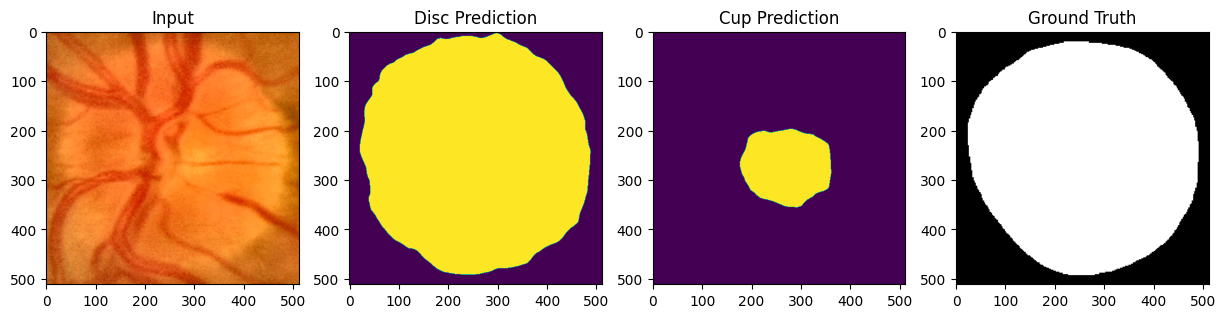

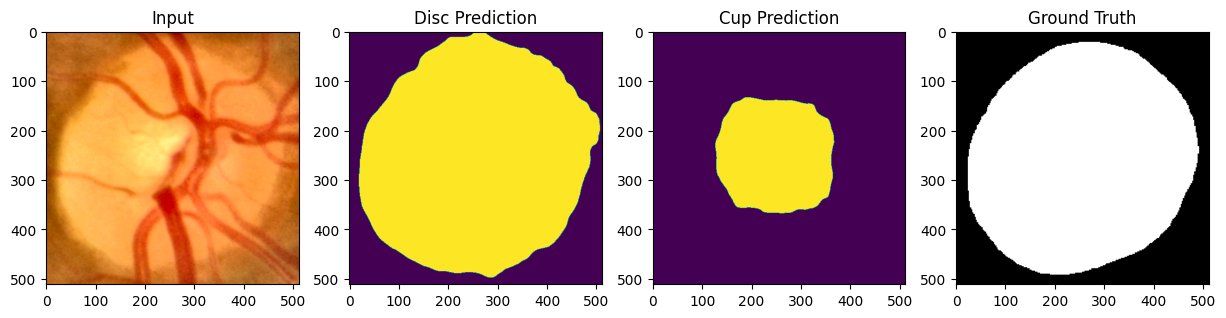

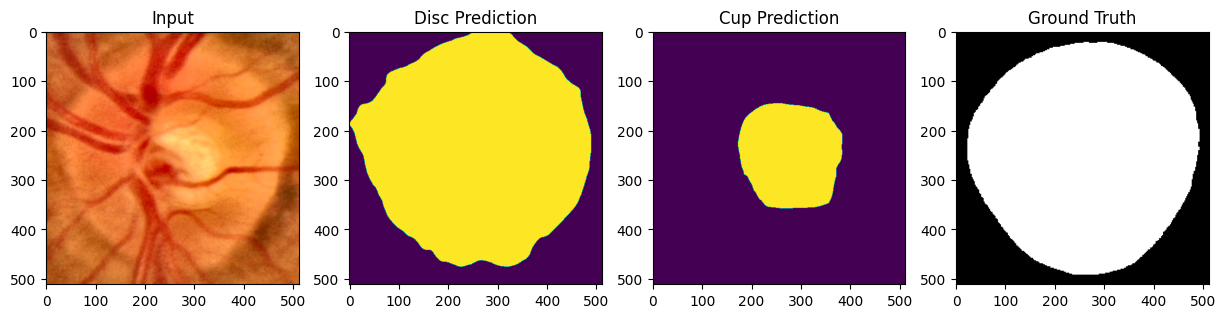

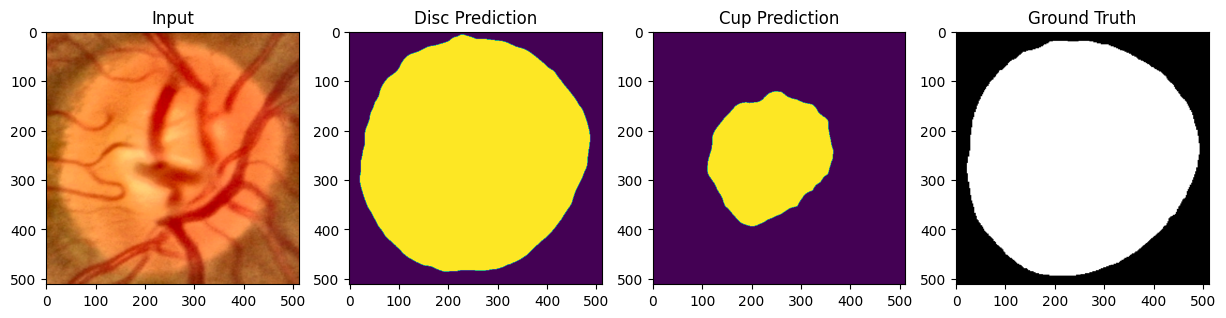

In [9]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import DataLoader
import albumentations as A
!pip install segmentation_models_pytorch

import segmentation_models_pytorch as smp
from torch.optim import lr_scheduler
from PIL import Image
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2 as ToTensor
from torchvision.transforms import v2
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, jaccard_score

# Step 1: Correct the path
images_path = 'Dataset/ProcessedImages/Images'

# Step 2: Check if images are in the directory
if not os.path.exists(images_path) or not os.listdir(images_path):
    print(f"No images found in {images_path}")
    exit(1)

def pad_to_32(x):
    h, w = x.shape[-2:]
    h_pad = 0 if h % 32 == 0 else 32 - h % 32
    w_pad = 0 if w % 32 == 0 else 32 - w % 32
    return F.pad(x, (0, w_pad, 0, h_pad))

# Define DataFrame for all data
all_img_paths = sorted(glob(os.path.join('ProcessedImages/Images', '*.png')))
all_disc_mask_paths = sorted(glob(os.path.join('ProcessedImages/DiscMasks', '*.tif')))
all_cup_mask_paths = sorted(glob(os.path.join('ProcessedImages/CupMasks', '*-cup.tif')))

# Split the data into training and testing sets for disc model
train_img_paths, test_img_paths, train_disc_mask_paths, test_disc_mask_paths = train_test_split(
    all_img_paths, all_disc_mask_paths, test_size=0.2, random_state=42)

# Split the data into training and testing sets for cup model
train_img_paths_cup, test_img_paths_cup, train_cup_mask_paths, test_cup_mask_paths = train_test_split(
    all_img_paths, all_cup_mask_paths, test_size=0.2, random_state=42)

# Define DataFrame for disc training data
disc_train_df = pd.DataFrame({"images": train_img_paths, "masks": train_disc_mask_paths})

# Define DataFrame for disc test data
disc_test_df = pd.DataFrame({"images": test_img_paths, "masks": test_disc_mask_paths})

# Define DataFrame for cup training data
cup_train_df = pd.DataFrame({"images": train_img_paths_cup, "masks": train_cup_mask_paths})

# Define DataFrame for cup test data
cup_test_df = pd.DataFrame({"images": test_img_paths_cup, "masks": test_cup_mask_paths})

# Define transformations for training and test data
train_transforms = A.Compose([
    A.Resize(576, 576),
    A.RandomCrop(height=512, width=512, always_apply=True),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-15,15), p=0.5),
])

test_transforms = A.Compose([
    A.Resize(512, 512),
])

# Define custom Dataset class
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_=None):
        self.df = dataframe
        self.transforms_ = transforms_
        self.pre_normalize = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        self.resize = [512, 512]
        self.class_size = 2

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<127, 0, 1).astype(np.int16)
        aug = self.transforms_(image=img, mask=mask)
        img, mask = aug['image'], aug['mask']
        img = img/255
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
        target = torch.tensor(mask, dtype=torch.long)
        sample = {'x': img, 'y': target}
        return sample

# Define Dataset for disc model
disc_train_dataset = MyDataset(disc_train_df, train_transforms)
disc_val_dataset = MyDataset(disc_test_df, test_transforms)

# Define Dataset for cup model
cup_train_dataset = MyDataset(cup_train_df, train_transforms)
cup_val_dataset = MyDataset(cup_test_df, test_transforms)

# Set batch size
BATCH_SIZE = 4

# Create data loaders for disc model
disc_train_loader = DataLoader(disc_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
disc_val_loader = DataLoader(disc_val_dataset, batch_size=BATCH_SIZE)

# Create data loaders for cup model
cup_train_loader = DataLoader(cup_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
cup_val_loader = DataLoader(cup_val_dataset, batch_size=BATCH_SIZE)

# Define disc model
disc_model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)
disc_model.cuda()

# Define cup model
cup_model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)
cup_model.cuda()

# Define loss function for both models
loss_fn = smp.losses.DiceLoss(mode="binary")

# Define optimizer for disc model
disc_optimizer = torch.optim.Adam(disc_model.parameters(), lr=0.001)

# Define optimizer for cup model
cup_optimizer = torch.optim.Adam(cup_model.parameters(), lr=0.001)

# Define learning rate scheduler for disc model
disc_scheduler = lr_scheduler.StepLR(disc_optimizer, step_size=100, gamma=0.1)

# Define learning rate scheduler for cup model
cup_scheduler = lr_scheduler.StepLR(cup_optimizer, step_size=100, gamma=0.1)

# Define number of epochs
EPOCHS = 50

# Define paths for saving/loading model checkpoints
disc_checkpoint_path = 'models/segmentationDISC.pth'
cup_checkpoint_path = 'models/segmentationCUP.pth'

disc_train_losses = []
cup_train_losses = []

# Training loop for disc model
for epoch in tqdm(range(EPOCHS)):
    disc_model.train()
    disc_epoch_loss = 0.0
    for batch in disc_train_loader:
        inputs, targets = batch['x'].cuda(), batch['y'].cuda()
        disc_optimizer.zero_grad()
        outputs = disc_model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        disc_optimizer.step()
        disc_epoch_loss += loss.item() * inputs.size(0)
    disc_epoch_loss /= len(disc_train_loader.dataset)
    disc_train_losses.append(disc_epoch_loss)
    disc_scheduler.step()
    # Save model checkpoint
    torch.save(disc_model.state_dict(), disc_checkpoint_path)

# Load disc model checkpoint
disc_model.load_state_dict(torch.load(disc_checkpoint_path))

# Training loop for cup model
for epoch in tqdm(range(EPOCHS)):
    cup_model.train()
    cup_epoch_loss = 0.0
    for batch in cup_train_loader:
        inputs, targets = batch['x'].cuda(), batch['y'].cuda()
        cup_optimizer.zero_grad()
        outputs = cup_model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        cup_optimizer.step()
        cup_epoch_loss += loss.item() * inputs.size(0)
    cup_epoch_loss /= len(cup_train_loader.dataset)
    cup_train_losses.append(cup_epoch_loss)
    cup_scheduler.step()
    # Save model checkpoint
    torch.save(cup_model.state_dict(), cup_checkpoint_path)

# Load cup model checkpoint
cup_model.load_state_dict(torch.load(cup_checkpoint_path))




# Visualize predictions for both disc and cup models side by side
show_imgs = 4
random_list = np.random.choice(len(disc_val_dataset), show_imgs, replace=False)

# Compute precision, F1 score, and IOU score for disc model
def compute_metrics(model, data_loader):
    model.eval()
    predictions = []
    targets = []
    for batch in data_loader:
        inputs, labels = batch['x'].cuda(), batch['y'].cuda()
        with torch.no_grad():
            outputs = model(inputs)
        predictions.extend(torch.sigmoid(outputs).cpu().numpy())
        targets.extend(labels.cpu().numpy())
    predictions = np.vstack(predictions)
    targets = np.vstack(targets)
    predictions = np.where(predictions < 0.5, 0, 1)

    precision = precision_score(targets.flatten(), predictions.flatten())
    f1 = f1_score(targets.flatten(), predictions.flatten())
    iou = jaccard_score(targets.flatten(), predictions.flatten())

    return precision, f1, iou

disc_precision, disc_f1, disc_iou = compute_metrics(disc_model, disc_val_loader)
cup_precision, cup_f1, cup_iou = compute_metrics(cup_model, cup_val_loader)

print("Disc Model Metrics:")
print(f"Precision: {disc_precision}")
print(f"F1 Score: {disc_f1}")
print(f"IoU Score: {disc_iou}")

print("Cup Model Metrics:")
print(f"Precision: {cup_precision}")
print(f"F1 Score: {cup_f1}")
print(f"IoU Score: {cup_iou}")


plt.figure(figsize=(10, 5))
plt.plot(range(EPOCHS), disc_train_losses, label='Disc Training Loss')
plt.plot(range(EPOCHS), cup_train_losses, label='Cup Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.show()

for i in range(show_imgs):
    idx = random_list[i]
    sample = disc_val_dataset[idx]

    # Make prediction using disc model
    disc_pred = disc_model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    disc_pred = torch.sigmoid(disc_pred).squeeze(0).squeeze(0)
    disc_pred = disc_pred.data.cpu().numpy()
    disc_pred = np.where(disc_pred < 0.5, 0, 1).astype(np.int16)
    disc_pred_img = Image.fromarray(np.uint8(disc_pred), 'L')

    # Make prediction using cup model
    cup_pred = cup_model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
    cup_pred = torch.sigmoid(cup_pred).squeeze(0).squeeze(0)
    cup_pred = cup_pred.data.cpu().numpy()
    cup_pred = np.where(cup_pred < 0.5, 0, 1).astype(np.int16)
    cup_pred_img = Image.fromarray(np.uint8(cup_pred), 'L')

    img_view = sample['x'].permute(1, 2, 0).cpu().numpy()
    img_view = (img_view * 255).astype(np.uint8)
    img_view = Image.fromarray(img_view, 'RGB')

    disc_mask_view = disc_pred_img
    cup_mask_view = cup_pred_img

    f, axarr = plt.subplots(1, 4, figsize=(15, 5))
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(disc_mask_view)
    axarr[1].set_title('Disc Prediction')
    axarr[2].imshow(cup_mask_view)
    axarr[2].set_title('Cup Prediction')
    axarr[3].imshow(sample['y'], cmap='gray')
    axarr[3].set_title('Ground Truth')
    plt.show()


No images found in Dataset/ProcessedImages/Images
                          images                             masks
0  ProcessedImages/Images/59.png  ProcessedImages/DiscMasks/59.tif
1  ProcessedImages/Images/89.png  ProcessedImages/DiscMasks/89.tif
2  ProcessedImages/Images/32.png  ProcessedImages/DiscMasks/32.tif
3  ProcessedImages/Images/47.png  ProcessedImages/DiscMasks/47.tif
4  ProcessedImages/Images/71.png  ProcessedImages/DiscMasks/71.tif
                          images                             masks
0  ProcessedImages/Images/84.png  ProcessedImages/DiscMasks/84.tif
1  ProcessedImages/Images/57.png  ProcessedImages/DiscMasks/57.tif
2  ProcessedImages/Images/72.png  ProcessedImages/DiscMasks/72.tif
3   ProcessedImages/Images/5.png   ProcessedImages/DiscMasks/5.tif
4  ProcessedImages/Images/49.png  ProcessedImages/DiscMasks/49.tif
cuda
len train: 80
len val: 20
torch.Size([1, 1, 512, 512])


  0%|          | 0/150 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.1674, val_loss: 0.2065     train_iou_score: 0.854, val_iou_score: 0.745     lr: 0.001


  1%|          | 1/150 [00:09<24:17,  9.78s/it]

EPOCH: 002     train_loss: 0.0728, val_loss: 0.0772     train_iou_score: 0.923, val_iou_score: 0.901     lr: 0.001


  1%|▏         | 2/150 [00:19<23:49,  9.66s/it]

EPOCH: 003     train_loss: 0.0509, val_loss: 0.0762     train_iou_score: 0.931, val_iou_score: 0.882     lr: 0.001


  2%|▏         | 3/150 [00:29<23:46,  9.70s/it]

EPOCH: 004     train_loss: 0.0439, val_loss: 0.0446     train_iou_score: 0.932, val_iou_score: 0.931     lr: 0.001


  3%|▎         | 4/150 [00:38<23:18,  9.58s/it]

EPOCH: 005     train_loss: 0.0387, val_loss: 0.0512     train_iou_score: 0.937, val_iou_score: 0.915     lr: 0.0001


  3%|▎         | 5/150 [00:47<22:33,  9.33s/it]

EPOCH: 006     train_loss: 0.0362, val_loss: 0.0436     train_iou_score: 0.940, val_iou_score: 0.927     lr: 0.0001


  4%|▍         | 6/150 [00:57<22:42,  9.46s/it]

EPOCH: 007     train_loss: 0.0351, val_loss: 0.0383     train_iou_score: 0.941, val_iou_score: 0.937     lr: 0.0001


  5%|▍         | 7/150 [01:06<22:12,  9.32s/it]

EPOCH: 008     train_loss: 0.0347, val_loss: 0.0421     train_iou_score: 0.942, val_iou_score: 0.929     lr: 0.0001


  5%|▌         | 8/150 [01:14<21:41,  9.16s/it]

EPOCH: 009     train_loss: 0.0332, val_loss: 0.0372     train_iou_score: 0.944, val_iou_score: 0.938     lr: 0.0001


  6%|▌         | 9/150 [01:24<21:48,  9.28s/it]

EPOCH: 010     train_loss: 0.0321, val_loss: 0.0386     train_iou_score: 0.946, val_iou_score: 0.935     lr: 1e-05


  7%|▋         | 10/150 [01:33<21:18,  9.13s/it]

EPOCH: 011     train_loss: 0.0316, val_loss: 0.0387     train_iou_score: 0.947, val_iou_score: 0.935     lr: 1e-05


  7%|▋         | 11/150 [01:42<20:58,  9.05s/it]

EPOCH: 012     train_loss: 0.0314, val_loss: 0.0383     train_iou_score: 0.948, val_iou_score: 0.936     lr: 1e-05


  8%|▊         | 12/150 [01:51<20:46,  9.03s/it]

EPOCH: 013     train_loss: 0.0316, val_loss: 0.0372     train_iou_score: 0.947, val_iou_score: 0.938     lr: 1e-05


  9%|▊         | 13/150 [02:00<20:42,  9.07s/it]

EPOCH: 014     train_loss: 0.0312, val_loss: 0.0381     train_iou_score: 0.948, val_iou_score: 0.936     lr: 1e-05


  9%|▉         | 14/150 [02:09<20:29,  9.04s/it]

EPOCH: 015     train_loss: 0.0300, val_loss: 0.0373     train_iou_score: 0.950, val_iou_score: 0.938     lr: 1.0000000000000002e-06


 10%|█         | 15/150 [02:18<20:14,  8.99s/it]

EPOCH: 016     train_loss: 0.0319, val_loss: 0.0392     train_iou_score: 0.946, val_iou_score: 0.934     lr: 1.0000000000000002e-06


 11%|█         | 16/150 [02:26<19:58,  8.94s/it]

EPOCH: 017     train_loss: 0.0300, val_loss: 0.0384     train_iou_score: 0.950, val_iou_score: 0.936     lr: 1.0000000000000002e-06


 11%|█▏        | 17/150 [02:35<19:47,  8.93s/it]

EPOCH: 018     train_loss: 0.0318, val_loss: 0.0371     train_iou_score: 0.946, val_iou_score: 0.938     lr: 1.0000000000000002e-06


 12%|█▏        | 18/150 [02:45<19:59,  9.09s/it]

EPOCH: 019     train_loss: 0.0309, val_loss: 0.0381     train_iou_score: 0.948, val_iou_score: 0.936     lr: 1.0000000000000002e-06


 13%|█▎        | 19/150 [02:54<19:40,  9.01s/it]

EPOCH: 020     train_loss: 0.0289, val_loss: 0.0379     train_iou_score: 0.952, val_iou_score: 0.937     lr: 1.0000000000000002e-07


 13%|█▎        | 20/150 [03:03<19:29,  8.99s/it]

EPOCH: 021     train_loss: 0.0308, val_loss: 0.0366     train_iou_score: 0.948, val_iou_score: 0.939     lr: 1.0000000000000002e-07


 14%|█▍        | 21/150 [03:12<19:28,  9.05s/it]

EPOCH: 022     train_loss: 0.0304, val_loss: 0.0371     train_iou_score: 0.949, val_iou_score: 0.938     lr: 1.0000000000000002e-07


 15%|█▍        | 22/150 [03:21<19:17,  9.04s/it]

EPOCH: 023     train_loss: 0.0291, val_loss: 0.0377     train_iou_score: 0.952, val_iou_score: 0.937     lr: 1.0000000000000002e-07


 15%|█▌        | 23/150 [03:30<19:04,  9.01s/it]

EPOCH: 024     train_loss: 0.0303, val_loss: 0.0372     train_iou_score: 0.949, val_iou_score: 0.938     lr: 1.0000000000000002e-07


 16%|█▌        | 24/150 [03:39<18:51,  8.98s/it]

EPOCH: 025     train_loss: 0.0310, val_loss: 0.0381     train_iou_score: 0.948, val_iou_score: 0.936     lr: 1.0000000000000004e-08


 17%|█▋        | 25/150 [03:48<18:44,  8.99s/it]

EPOCH: 026     train_loss: 0.0302, val_loss: 0.0368     train_iou_score: 0.950, val_iou_score: 0.939     lr: 1.0000000000000004e-08


 17%|█▋        | 25/150 [03:57<19:45,  9.48s/it]

Earlystop!


Threshold: 0.3     IoU Score: 0.937     Precision: 0.948     F1 Score: 0.967     Recall: 0.988     Accuracy: 0.956
Threshold: 0.4     IoU Score: 0.938     Precision: 0.950     F1 Score: 0.968     Recall: 0.987     Accuracy: 0.957
Threshold: 0.5     IoU Score: 0.939     Precision: 0.951     F1 Score: 0.968     Recall: 0.986     Accuracy: 0.957
Threshold: 0.6     IoU Score: 0.939     Precision: 0.952     F1 Score: 0.969     Recall: 0.986     Accuracy: 0.958
Threshold: 0.7     IoU Score: 0.940     Precision: 0.954     F1 Score: 0.969     Recall: 0.985     Accuracy: 0.958


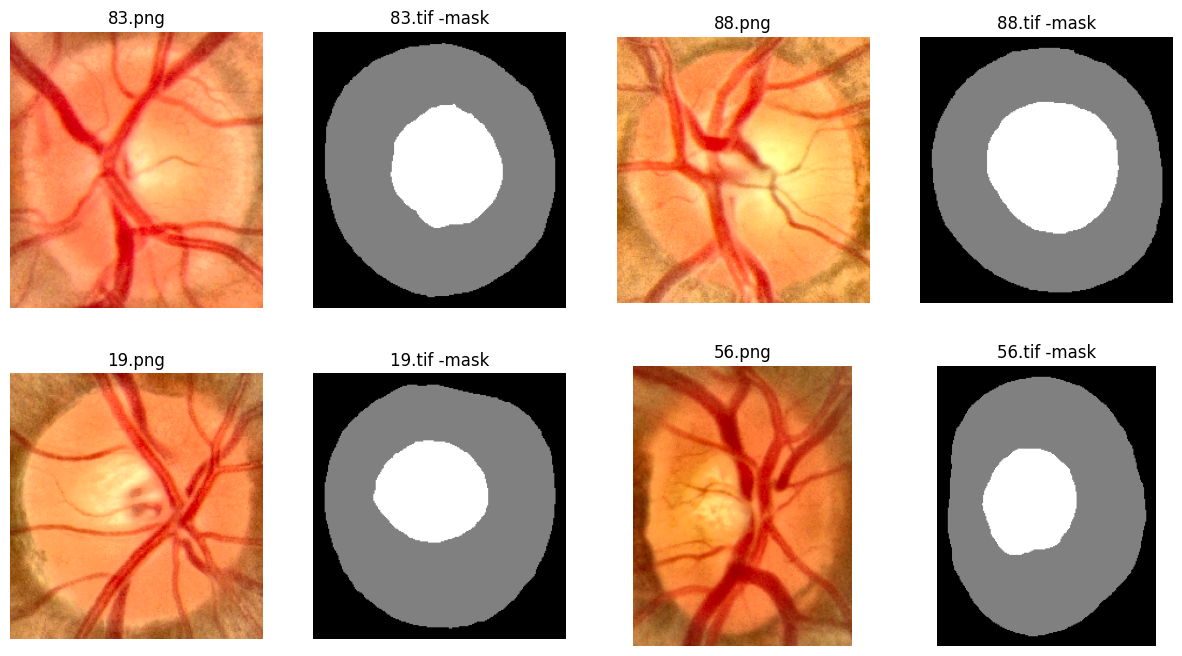

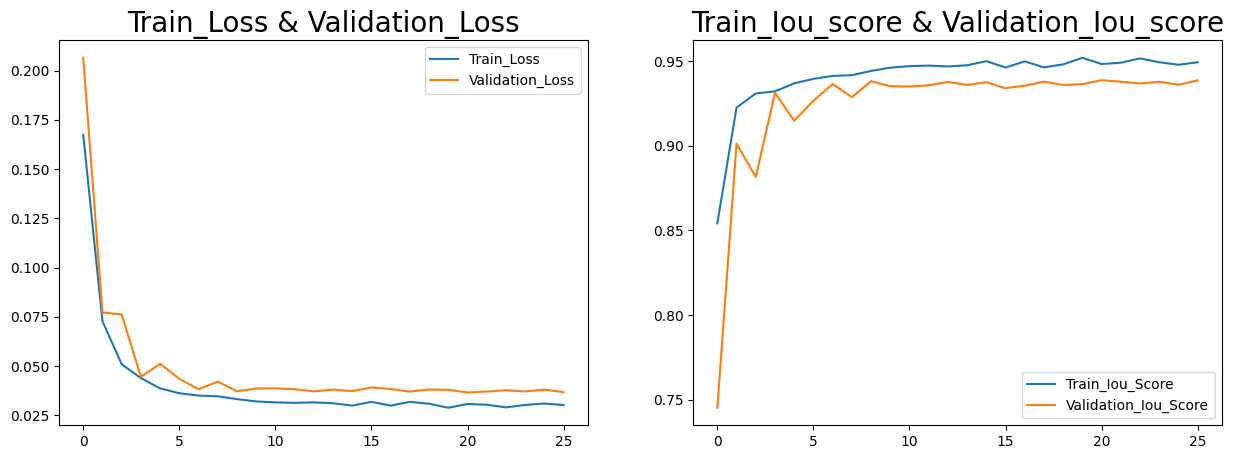

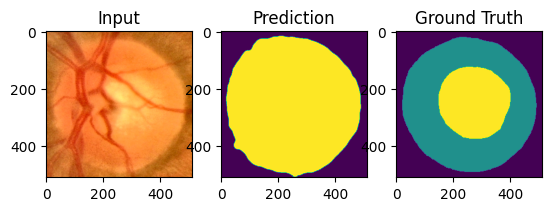

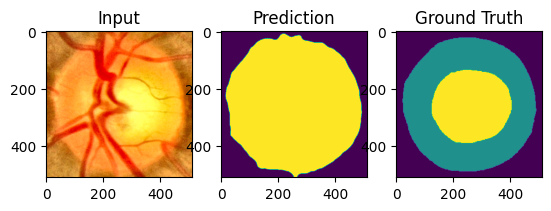

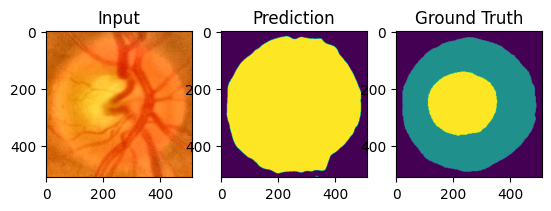

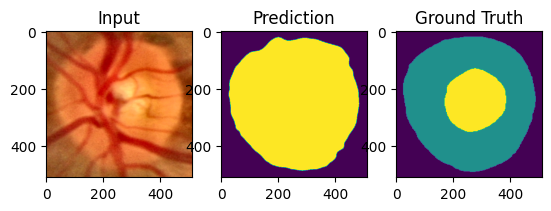

In [7]:
# import os
# from glob import glob
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2
# import torch
# from torch.utils.data import DataLoader
# import albumentations as A
# !pip install segmentation_models_pytorch
# import segmentation_models_pytorch as smp
# from torch.optim import lr_scheduler
# from PIL import Image
# from tqdm import tqdm
# from albumentations.pytorch import ToTensorV2 as ToTensor
# from torchvision.transforms import v2
# import torch.nn.functional as F
# from sklearn.model_selection import train_test_split


# # Step 1: Correct the path
# images_path = 'Dataset/ProcessedImages/Images'

# # Step 2: Check if images are in the directory
# if not os.path.exists(images_path) or not os.listdir(images_path):
#     print(f"No images found in {images_path}")
#     exit(1)

# def pad_to_32(x):
#     h, w = x.shape[-2:]
#     h_pad = 0 if h % 32 == 0 else 32 - h % 32
#     w_pad = 0 if w % 32 == 0 else 32 - w % 32
#     return F.pad(x, (0, w_pad, 0, h_pad))

# # Set your root directory

# # Define DataFrame for all data
# # all_img_paths = sorted(glob(os.path.join('Dataset/ProcessedImages/Images', '*.png')))
# # all_mask_paths = sorted(glob(os.path.join('Dataset/ProcessedImages/Masks', '*.tif')))

# all_img_paths = sorted(glob(os.path.join('ProcessedImages/Images', '*.png')))
# all_mask_paths = sorted(glob(os.path.join('ProcessedImages/DiscMasks', '*.tif')))


# # Split the data into training and testing sets
# train_img_paths, test_img_paths, train_mask_paths, test_mask_paths = train_test_split(
#     all_img_paths, all_mask_paths, test_size=0.2, random_state=42)

# # Define DataFrame for training data
# train_df = pd.DataFrame({"images": train_img_paths, "masks": train_mask_paths})

# # Define DataFrame for test data
# test_df = pd.DataFrame({"images": test_img_paths, "masks": test_mask_paths})


# print(train_df.head())
# print(test_df.head())

# #Show the Images
# show_imgs = 4
# idx = np.random.choice(len(train_df), show_imgs, replace=False)
# fig, axes = plt.subplots(show_imgs*2//4, 4, figsize=(15, 8))
# axes = axes.flatten()
# for i, ax in enumerate(axes):
#     new_i = i//2
#     if i % 2 ==0 :
#         full_path = train_df.loc[idx[new_i]]['images']
#         basename = os.path.basename(full_path)
#     else:
#         full_path = train_df.loc[idx[new_i]]['masks']
#         basename = os.path.basename(full_path) + ' -mask'
#     ax.imshow(plt.imread(full_path))
#     ax.set_title(basename)
#     ax.set_axis_off()

# # Define transformations for training and test data
# train_transforms = A.Compose([
#     A.Resize(576, 576),
#     A.RandomCrop(height=512, width=512, always_apply=True),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.01, scale_limit=(-0.04,0.04), rotate_limit=(-15,15), p=0.5),
#     # A.Normalize(p=1.0)
# ])

# test_transforms = A.Compose([
#     A.Resize(512, 512),
#     # ToTensor(),
# ])

# # Define custom Dataset class
# class MyDataset(torch.utils.data.Dataset):
#     def __init__(self, dataframe, transforms_=None):
#         self.df = dataframe
#         self.transforms_ = transforms_
#         self.pre_normalize = v2.Compose([v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
#         self.resize = [512, 512]
#         self.class_size = 2

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(self.df.iloc[index]['masks'],cv2.IMREAD_GRAYSCALE)
#         mask = np.where(mask<127, 0, 1).astype(np.int16)
#         aug = self.transforms_(image=img, mask=mask)
#         img, mask = aug['image'], aug['mask']
#         img = img/255
#         # img = self.pre_normalize(img)
#         img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
#         target = torch.tensor(mask, dtype=torch.long)
#         # img = pad_to_32(img)
#         # target = pad_to_32(target)
#         sample = {'x': img, 'y': target}
#         return sample


# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)


# # Create train and test datasets
# train_dataset = MyDataset(train_df, train_transforms)
# val_dataset = MyDataset(test_df, test_transforms)

# # Set batch size
# BATCH_SIZE = 4

# # Create data loaders
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# print(f'len train: {len(train_df)}')
# print(f'len val: {len(test_df)}')

# # Define model
# model = smp.Unet(
#     encoder_name="resnet50",
#     encoder_weights="imagenet",
#     in_channels=3,
#     classes=1,
# )
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model.cuda()  # Move the model to the GPU

# print(model(torch.randn((1,3,512,512)).cuda()).shape)


# #Training and Evaluation Functions
# def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
#     size = len(dataloader.dataset) # number of samples
#     num_batches = len(dataloader) # batches per epoch
#     model.train() # to training mode.
#     epoch_loss = 0
#     epoch_iou_score = 0
#     for batch_i, batch in enumerate(dataloader):
#         x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
#         optimizer.zero_grad()
#         pred = model(x)
#         loss = loss_fn(pred, y)

#         loss.backward() # backpropagation to compute gradients
#         optimizer.step() # update model params

#         epoch_loss += loss.item() # tensor -> python value
#         pred = pred.squeeze(dim=1)
#         pred = torch.sigmoid(pred)
#         y = y.round().long()
#         tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
#         iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
#         # print(f'train_acc: {acc}')
#         epoch_iou_score += iou_score
#         lr_scheduler.step()
#     # return avg loss of epoch, acc of epoch
#     return epoch_loss/num_batches, epoch_iou_score/num_batches



# def test(dataloader, model, loss_fn):
#     size = len(dataloader.dataset) # number of samples
#     num_batches = len(dataloader) # batches per epoch

#     model.eval() # model to test mode.
#     epoch_loss = 0
#     epoch_iou_score = 0
#     # No gradient for test data
#     with torch.no_grad():
#         for batch_i, batch in enumerate(dataloader):
#             x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU

#             # Compute prediction loss
#             pred = model(x)
#             loss = loss_fn(pred, y)

#             # write to logs
#             epoch_loss += loss.item()
#             pred = pred.squeeze(dim=1)
#             pred = torch.sigmoid(pred)
#             y = y.round().long()
#             tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
#             iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
#             # print(f'val_acc: {acc}')
#             epoch_iou_score += iou_score
#             # size += y.shape[0]
#     return epoch_loss/num_batches, epoch_iou_score/num_batches




# # Define loss function
# loss_fn = smp.losses.DiceLoss(mode="binary")

# # Define optimizer
# learning_rate = 0.001
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # Define learning rate scheduler
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

# # Define number of epochs
# EPOCHS = 150

# # Define logging dictionary
# logs = {'train_loss': [], 'val_loss': [], 'train_iou_score': [], 'val_iou_score': []}


# best_loss = np.inf
# # Training loop
# for epoch in tqdm(range(EPOCHS)):
#     train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
#     val_loss, val_iou_score = test(val_loader, model, loss_fn)
#     logs['train_loss'].append(train_loss)
#     logs['val_loss'].append(val_loss)
#     logs['train_iou_score'].append(train_iou_score)
#     logs['val_iou_score'].append(val_iou_score)

#     print(f'EPOCH: {str(epoch+1).zfill(3)} \
#     train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
#     train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
#     lr: {optimizer.param_groups[0]["lr"]}')

#     # Save model checkpoint
#     torch.save(model.state_dict(), "./models/New_segmentation.pth")

#     # Check for improvement and save best model
#     if val_loss < best_loss:
#         counter = 0
#         best_loss = val_loss
#         torch.save(model.state_dict(), "./models/New_segmentation.pth")
#     else:
#         counter += 1
#     if counter >= 5:
#         print("Earlystop!")
#         break

# # Plot training and validation metrics
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
# plt.plot(logs['train_loss'], label='Train_Loss')
# plt.plot(logs['val_loss'], label='Validation_Loss')
# plt.title('Train_Loss & Validation_Loss', fontsize=20)
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(logs['train_iou_score'], label='Train_Iou_Score')
# plt.plot(logs['val_iou_score'], label='Validation_Iou_Score')
# plt.title('Train_Iou_score & Validation_Iou_score', fontsize=20)
# plt.legend()

# # Define test Dataset class
# class TestDataset(torch.utils.data.Dataset):
#     def __init__(self, dataframe, transforms_=None):
#         self.df = dataframe
#         self.transforms_ = transforms_

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         img = cv2.cvtColor(cv2.imread(self.df.iloc[index]['images']), cv2.COLOR_BGR2RGB)
#         mask = cv2.imread(self.df.iloc[index]['masks'], cv2.IMREAD_GRAYSCALE)
#         aug = self.transforms_(image=img, mask=mask)
#         img, mask = aug['image'], aug['mask']
#         img_view = np.copy(img)
#         img = img / 255
#         img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1)
#         mask_view = np.copy(mask)
#         mask = np.where(mask < 127, 0, 1).astype(np.int16)
#         target = torch.tensor(mask, dtype=torch.long)
#         sample = {'x': img, 'y': target, 'img_view': img_view, 'mask_view': mask_view}
#         return sample

# # Create test dataset and DataLoader
# test_dataset = TestDataset(test_df, test_transforms)
# test_loader = DataLoader(test_dataset, batch_size=4)

# # Load best model checkpoint
# model.load_state_dict(torch.load('./models/New_segmentation.pth'))
# model.to(device)

# def get_metrics(model, dataloder, threshold):
#     IoU_score, precision, f1_score, recall, acc= 0, 0, 0, 0, 0
#     batchs = 0
#     model.eval()
#     with torch.no_grad():
#         for batch_i, batch in enumerate(dataloder):
#             x, y = batch['x'].to(device), batch['y'].to(device) # move data to GPU
#             pred = model(x)
#             pred = pred.squeeze(dim=1)
#             pred = torch.sigmoid(pred)
#             y = y.round().long()
#             tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=threshold)
#             batch_iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
#             batch_acc = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
#             batch_f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
#             batch_recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
#             batch_precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()
#             IoU_score += batch_iou_score
#             acc += batch_acc
#             f1_score += batch_f1_score
#             recall += batch_recall
#             precision += batch_precision
#             batchs += 1
#     IoU_score = round(IoU_score/batchs, 3)
#     precision = round(precision/batchs, 3)
#     f1_score = round(f1_score/batchs, 3)
#     recall = round(recall/batchs, 3)
#     acc = round(acc/batchs, 3)
#     sample = {'iou':IoU_score, 'pre':precision, 'fi':f1_score, 're':recall, 'acc':acc}
#     return sample

# # Define threshold list
# threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7]

# # Evaluate model on test set with different thresholds
# for threshold in threshold_list:
#     sample = get_metrics(model, test_loader, threshold)
#     print(f"Threshold: {str(threshold)} \
#     IoU Score: {sample['iou']:.3f} \
#     Precision: {sample['pre']:.3f} \
#     F1 Score: {sample['fi']:.3f} \
#     Recall: {sample['re']:.3f} \
#     Accuracy: {sample['acc']:.3f}")

# # Visualize predictions
# show_imgs = 4
# random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

# for i in range(show_imgs):
#     idx = random_list[i]
#     sample = test_dataset[idx]
#     pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))
#     pred = torch.sigmoid(pred).squeeze(0).squeeze(0)
#     pred = pred.data.cpu().numpy()
#     pred = np.where(pred < 0.5, 0, 1).astype(np.int16)
#     pred_img = Image.fromarray(np.uint8(pred), 'L')

#     img_view = sample['img_view']
#     img_view = Image.fromarray(img_view, 'RGB')

#     mask_view = sample['mask_view']
#     mask_view = Image.fromarray(mask_view, 'L')

#     f, axarr = plt.subplots(1, 3)
#     axarr[0].imshow(img_view)
#     axarr[0].set_title('Input')
#     axarr[1].imshow(pred_img)
#     axarr[1].set_title('Prediction')
#     axarr[2].imshow(mask_view)
#     axarr[2].set_title('Ground Truth')
#     plt.show()
